# Binary / Binomial Data (replicating [the R package's vignette](https://github.com/stan-dev/rstanarm/blob/master/vignettes/binomial.Rmd))

In [1]:
%load_ext autoreload
%autoreload 2

from bayesglm import stan_glm, priors, family
import pandas as pd
from ggplot import gg, ggplot_notebook
import numpy as np
from scipy.special import logit, expit
from rpy2 import robjects

In [2]:
# Load data and create dist100 variable 
wells = pd.read_csv("../data/wells.csv") # This isn't in git yet, but I think it would be safe to put it there
wells['dist100'] = wells.dist / 100

In [3]:
wells.head()

,switch,arsenic,dist,assoc,educ,dist100
0,1,2.36,16.826000,0,0,0.16826
1,1,0.71,47.321999,0,0,0.47322
2,0,2.07,20.966999,0,10,0.20967
3,1,1.15,21.486000,0,12,0.21486
4,1,1.10,40.874001,1,14,0.40874


In [4]:
p = gg.ggplot(wells) + \
    gg.aes_string(x = "dist100") + \
    gg.geom_histogram() + \
    gg.facet_grid("switch ~ .", scales = "free_y")
    
# p = gg.ggplot(wells) + \
#     gg.aes_string(x = "dist100", fill = "factor(switch)") + \
#     gg.geom_histogram(gg.aes_string(y = "..density..", group = "factor(switch)"), alpha = .3) + 
#     gg.stat_bin()
    

/Users/david/miniconda3/lib/python3.5/site-packages/rpy2/robjects/lib/ggplot2.py:87: UserWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  self._rprint(self, vp = vp)


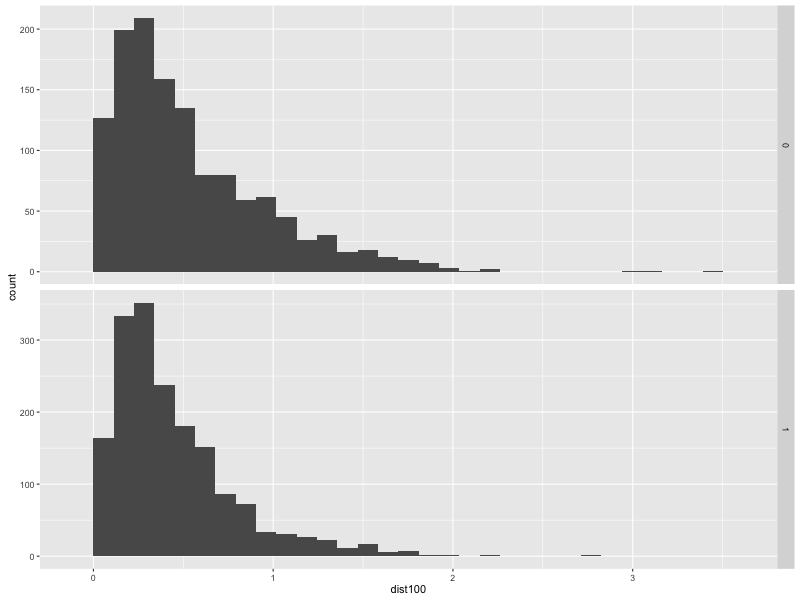

In [5]:
ggplot_notebook(p)

In [6]:
t_prior = priors.StudentTPrior(7, 0, 2.5)


In [7]:
fit1 = stan_glm("switch ~ dist100", wells, 
                 family = family.bernoulli_logit(), 
                 priors = {"Intercept": t_prior, "dist100": t_prior})

Using cached StanModel


In [8]:
fit1

Inference for Stan model: anon_model_f56b2b4ad58820b9cf829cfe3b383e9d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]    0.6  2.3e-3   0.06   0.49   0.56    0.6   0.65   0.72    667    1.0
beta[1]  -0.62  3.8e-3    0.1  -0.81  -0.68  -0.61  -0.55  -0.43    656    1.0
lp__     -2039    0.04   0.96  -2041  -2039  -2038  -2038  -2038    731    1.0

Samples were drawn using NUTS(diag_e) at Sun Feb 14 14:05:18 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [9]:
posterior_samples = fit1.extract(permuted=True)['beta']
beta_intercept, beta_dist100 = np.mean(posterior_samples, axis=0)
pr_switch = lambda dist100: expit(beta_intercept + beta_dist100 * dist100)

In [10]:

dist100s = np.linspace(start = min(wells.dist100), stop = max(wells.dist100), num = 100)
pr_switch_df = pd.DataFrame({"dist100": dist100s, "switch": pr_switch(dist100s)})
pr_switch_df.head()

,dist100,switch
0,0.003870,0.645862
1,0.038127,0.641014
2,0.072384,0.636137
3,0.106641,0.631232
4,0.140898,0.626299


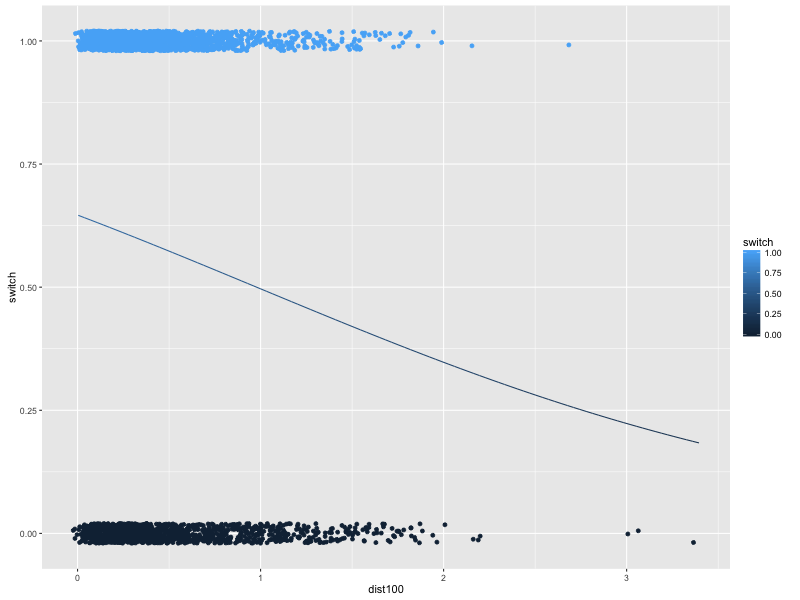

In [11]:
p = gg.ggplot(wells) + \
    gg.aes_string(x = "dist100", y = "switch", color = "switch") + \
    gg.geom_point(position = gg.position_jitter(height = .05, width = .1)) +\
    gg.geom_line(gg.aes_string(x="dist100", y="switch"), data = pr_switch_df)
ggplot_notebook(p)


In [12]:
fit2 = stan_glm("switch ~ dist100 + arsenic", wells, 
                 family = family.bernoulli_logit(), 
                 priors = {"Intercept": t_prior, "dist100": t_prior})

Using cached StanModel


In [13]:
fit2

Inference for Stan model: anon_model_f56b2b4ad58820b9cf829cfe3b383e9d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0] 1.1e-3  2.6e-3   0.07  -0.14  -0.05 4.4e-4   0.05   0.15    826    1.0
beta[1]   -0.9  3.6e-3    0.1  -1.11  -0.96   -0.9  -0.83  -0.69    865    1.0
beta[2]   0.46  1.5e-3   0.04   0.38   0.43   0.46   0.49   0.54    786    1.0
lp__     -1966    0.05   1.21  -1969  -1967  -1966  -1966  -1965    643    1.0

Samples were drawn using NUTS(diag_e) at Sun Feb 14 14:05:42 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [14]:
posterior_samples = fit2.extract(permuted=True)['beta']
beta_intercept, beta_dist100, beta_arsenic = np.mean(posterior_samples, axis=0)
pr_switch2 = lambda dist100, arsenic: expit(beta_intercept + beta_dist100 * dist100 + beta_arsenic * arsenic)

In [15]:
# pr_switch2 <- function(x, y, ests) plogis(ests[1] + ests[2] * x + ests[3] * y)
# grid <- expand.grid(dist100 = seq(0, 4, length.out = 100), 
#                     arsenic = seq(0, 10, length.out = 100))
# grid$prob <- with(grid, pr_switch2(dist100, arsenic, coef(fit2)))
# ggplot(grid, aes(x = dist100, y = arsenic)) + 
#   geom_tile(aes(fill = prob)) + 
#   geom_point(data = wells, aes(color = factor(switch)), size = 2, alpha = 0.85) + 
#   scale_fill_gradient() +
#   scale_color_manual("switch", values = c("white", "black"), labels = c("No", "Yes"))

In [16]:
pd.DataFrame(np.array(np.meshgrid(np.array([1,2,3]), np.array([11,12,13]), indexing="ij")).reshape(2, 9).transpose())

,0,1
0,1,11
1,1,12
2,1,13
3,2,11
4,2,12
5,2,13
6,3,11
7,3,12
8,3,13
